# Weather Forecasting using Timeseries Data

Dataset: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

* Weather timeseries dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany.
* In this dataset, 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes. 
* Build a model that takes as input some data from the recent past (a few days’ worth of data points) and predicts the air temperature 24 hours in the future.

## 1) Prepare the dataset

In [1]:
import os

In [2]:
data_dir = 'D:/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [4]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

View a sample

In [5]:
lines[2500]

'18.01.2009 08:50:00,980.94,1.77,276.45,0.15,88.90,6.94,6.17,0.77,3.92,6.29,1239.97,3.19,4.00,197.30'

In [6]:
len(lines[2500].split(","))

15

**The first value in each tuple indicates the time; The next 14 values are the features.**

Number of samples

In [7]:
len(lines)

420551

**Parse the data**

In [8]:
import numpy as np

In [9]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i,:] = values

In [10]:
float_data[2500]

array([9.80940e+02, 1.77000e+00, 2.76450e+02, 1.50000e-01, 8.89000e+01,
       6.94000e+00, 6.17000e+00, 7.70000e-01, 3.92000e+00, 6.29000e+00,
       1.23997e+03, 3.19000e+00, 4.00000e+00, 1.97300e+02])

In [11]:
float_data.shape

(420551, 14)

Let's plot the the temperature for the first 10 days; The data is recorded every 10 minutes and hence we have 144 samples per day. Hence for the first 10 days, we'll have to choose the first 1440 samples from the dataset.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

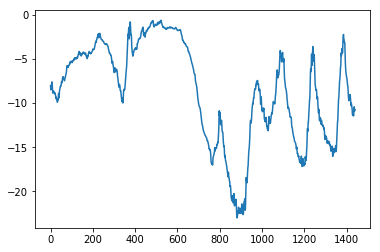

In [13]:
temp = float_data[:, 1]
plt.plot(range(1440), temp[:1440]);

## 2) Prepare data for ingestion

We will be using the first 200000 samples as training data. 

We define three variables and their values as follows:
* **lookback** = 720 — Observations will go back 5 days.
* **steps** = 6 — Observations will be sampled at one data point per hour.
* **delay** = 144 — Targets will be 24 hours in the future.

**a) Let's normalize the data. **

In [14]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

**b) Let's create a data generator which returns (samples, targets), where samples is the number of samples equal to batch size and targets is an array of target temperatures.**

We define the following parameters for the generator:
* data — The original array of normalized floating-point data.
* lookback — How many timesteps back the input data should go.
* delay — How many timesteps in the future the target should be.
* min_index and max_index — Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
* shuffle — Whether to shuffle the samples or draw them in chronological order.
* batch_size — The number of samples per batch.
* step — The period, in timesteps, at which you sample data. Set it to 6 in order to draw one data point every hour.

In [15]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

Let's create three generators for training (200000 samples), validation (next 100000) and testing (remaining).

In [16]:
# Past 10 days
lookback = 1440 

# 24 hours into the future
delay = 144  

step = 6
batch_size = 128

In [17]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

In [18]:
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

In [19]:
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

How many steps to draw from <i>val_gen</i> in order to see the entire validation set

In [20]:
val_steps = (300000 - 200001 - lookback)

How many steps to draw from <i>test_gen</i> in order to see the entire test set

In [21]:
test_steps = (len(float_data) - 300001 - lookback)

## 3) Build the model

Let's build a basic ML system and evaluate how it performs before adding a complex model.

**Architecture**
* 2 densely connected layers, _relu_ activation
* 1 output layer, no activation as this is a regression problem

In [25]:
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics

In [27]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.MAE)

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=1000)

Epoch 1/20
500/500 [==============================] - 14s 27ms/step - loss: 1.6571 - val_loss: 0.6089
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.6133 - val_loss: 0.4612
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.3406 - val_loss: 0.2942
Epoch 4/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2762 - val_loss: 0.3005
Epoch 5/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2597 - val_loss: 0.3012
Epoch 6/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2487 - val_loss: 0.3389
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2401 - val_loss: 0.3192
Epoch 8/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2320 - val_loss: 0.3286
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2276 - val_loss: 0.3182
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.223

#### Validation Loss: 0.33

Plotting the loss

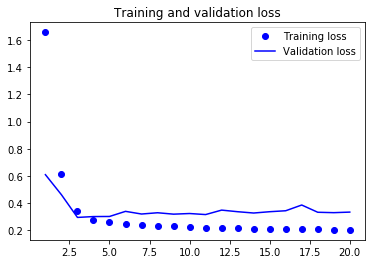

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();

### Recurrent Neural Net Approach

Let's use a GRU instead of the dense layers and see how the model performs.

In [31]:
model = models.Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.MAE)

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=1000)

Epoch 1/5
500/500 [==============================] - 199s 399ms/step - loss: 0.3039 - val_loss: 0.2809
Epoch 2/5
500/500 [==============================] - 199s 399ms/step - loss: 0.2820 - val_loss: 0.2673
Epoch 3/5
500/500 [==============================] - 195s 391ms/step - loss: 0.2768 - val_loss: 0.2657
Epoch 4/5
500/500 [==============================] - 195s 390ms/step - loss: 0.2734 - val_loss: 0.2669
Epoch 5/5
500/500 [==============================] - 201s 402ms/step - loss: 0.2673 - val_loss: 0.2645


#### Validation Loss: 0.2673

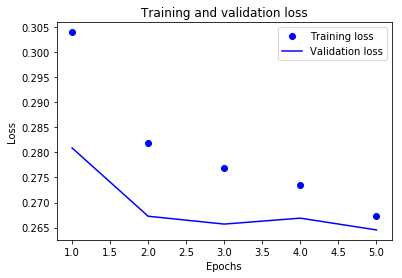

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

As seen here, we obtain an improvement using RNNs over using a densely connected model.

### Recurrent Neural Net with Dropout

Let's try adding dropout and seeing how the network performs.

In [35]:
model = models.Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.MAE)

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=1000)

Epoch 1/5
500/500 [==============================] - 225s 451ms/step - loss: 0.3330 - val_loss: 0.2723
Epoch 2/5
500/500 [==============================] - 219s 437ms/step - loss: 0.3159 - val_loss: 0.2739
Epoch 3/5
500/500 [==============================] - 219s 439ms/step - loss: 0.3084 - val_loss: 0.2758
Epoch 4/5
500/500 [==============================] - 217s 435ms/step - loss: 0.3018 - val_loss: 0.2728
Epoch 5/5
500/500 [==============================] - 216s 431ms/step - loss: 0.2991 - val_loss: 0.2658


#### Validation Loss: 0.2658

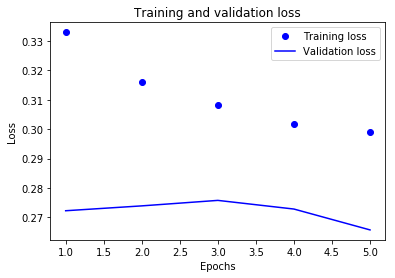

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

We can see that dropout marginally reduces the loss.

### Stacking Recurrent Neural Nets with Dropout

Let's add two GRU layer and see how it performs.

In [39]:
model = models.Sequential()
model.add(layers.GRU(32, 
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,
                     dropout=0.1,
                     activation=activations.relu,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.MAE)

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=1000)

Epoch 1/5
500/500 [==============================] - 465s 930ms/step - loss: 0.3336 - val_loss: 0.2794
Epoch 2/5
500/500 [==============================] - 456s 911ms/step - loss: 0.3142 - val_loss: 0.2763
Epoch 3/5
500/500 [==============================] - 459s 919ms/step - loss: 0.3063 - val_loss: 0.2683
Epoch 4/5
500/500 [==============================] - 469s 937ms/step - loss: 0.3023 - val_loss: 0.2773
Epoch 5/5
500/500 [==============================] - 457s 915ms/step - loss: 0.3024 - val_loss: 0.2692


As seen from the validation loss, there isn't much improvement here. 

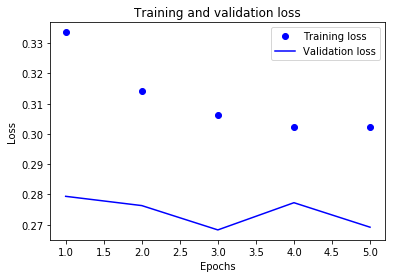

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

We can also try to use bidirectional RNNs to further reduce the loss, but I don't have a GPU powerful enough to continue. 
___